# System Identification - NLARX

Silverbox refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#Silverbox. 
It is a simulation of a [Duffing oscillator](https://en.wikipedia.org/wiki/Duffing_equation), ocurring for instance in nonlinear spring pendulums.

State-space model description of the system:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + c \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
c     =&\ \text{damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
v(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \tau^{-1}dt)$. The parameter $\tau$ represents the precision of the process. The measurement noise is also a Wiener process, $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$.

### Forecasting experiment

In this notebook, we will perform a forecasting experiment. The time-series will be split into a training and a validation part. In the training part, we will provide both input and output, and then infer parameters. In the forecasting part, we will only provide input. The parameters will be fixed to their inferred values and we will let the model make predictions for the output. Those predictions are evaluated against the true output.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = true;

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1)

131072

In [4]:
# Select training set
trn = collect(40101:131072)
input_trn = input[trn]
output_trn = output[trn]
T_trn = length(trn);

# Select validation set
val = 101:40100
input_val = input[val]
output_val = output[val]
T_val = length(val);

In [5]:
# Plot every n-th time-point to avoid figure size exploding
n = 100

if viz
    p1a = Plots.plot(1:n:T_trn, input_trn[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="training")    
    p1b = Plots.plot(1:n:T_trn, output_trn[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    p1 = plot(p1a, p1b, layout=(2,1))
    Plots.savefig(p1, "viz/training_set.png")
end

In [6]:
if viz
    p2a = Plots.plot(1:n:T_val, input_val[1:n:end], color="black", label="", markersize=2, xlabel="", ylabel="control", size=(1200,400), title="validation")    
    p2b = Plots.plot(1:n:T_val, output_val[1:n:end], color="black", label="", markersize=2, xlabel="time (t)", ylabel="output (displacement)", size=(1200,400))    
    p2 = plot(p2a, p2b, layout=(2,1))
    Plots.savefig(p2, "viz/validation_set.png")
end

## Solution steps

### 1. Discretize

I'm using a central difference for the second derivative and a forward difference for the first derivative. Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The state transition can now be written as the following discrete-time system:

$$\begin{align}
m (x_{t+1} - 2x_{t} + x_{t-1}) + c (x_{t+1} - x_{t}) + a x_t + b x_t^3 =&\ u_t + w_t
\end{align}$$
Re-writing this as a function of $x_{t+1}$ yields:
$$\begin{align}
% (m + c) x_{t+1}&\ + (-2m - c + a) x_{t} + bx_t^3 + m x_{t-1} = u_t + w_t \\
x_{t+1}&\ = \frac{2m + c - a}{m + c} x_{t} + \frac{-b}{m + c}x_t^3 + \frac{-m}{m + c} x_{t-1} + \frac{1}{m + c} u_t + \frac{1}{m + c} w_t \, .
\end{align}$$

### 2. Substitute variables and reduce order

I can cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{t+1} \\ x_{t} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} \underbrace{\begin{bmatrix} x_{t} \\ x_{t-1} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{e} g(z_{t-1}, \theta) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

where

$$\begin{align}
\theta_1 =&\ \frac{2m+c-a}{m+c} \\
\theta_2 =&\ \frac{-b}{m+c} \\
\theta_3 =&\ \frac{-m}{m+c} \\
\eta =&\ \frac{1}{m+c} \\
\gamma^{-1} =& \tau^{-1} \frac{1}{(m+c)^2} \, ,
\end{align}$$

and $g(z_{t-1}, \theta) = \theta_1 x_t + \theta_2 x_t^3 + \theta_3 x_{t-1}$ and $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. In total, I have five unknowns $m,c,a,b,\tau$ and five equations. I can invert the mapping between $\phi = (m, c, a, b, \tau)$ and $\psi = (\theta_1, \theta_2, \theta_3, \eta, \gamma)$ to recover MAP estimates for the physical parameters. Variable substitution allows for more freedom in choosing priors.

The system is now a nonlinear autoregressive process:

$$z_t = f(z_{t-1}, \theta, \eta, u_t) + \tilde{w}_t$$

where $f(z_{t-1}, \theta, \eta, u_t) = Sz_{t-1} + e g(z_{t-1}, \theta) + e \eta u_t$. Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 3. Convert to Gaussian probability

Integrating out $\tilde{w}_t$ and $v_t$ produces a Gaussian state transition node:

$$\begin{align}
z_t \sim&\ \mathcal{N}(f(z_{t-1}, \theta, \eta, u_t), V) \\
y_t \sim&\ \mathcal{N}(e^{\top} z_t, \xi^{-1}) \, ,
\end{align}$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $W = V^{-1} = \begin{bmatrix} \gamma & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

### 4. Approximating the nonlinearity

The nonlinearity is approximated using a first-order Taylor expansion. The work here revolves around working out the expectations for $g(x,\theta)$:

$$ g(x,\theta) = g(m_x, m_{\theta}) + J_{x}(m_x, m_{\theta})^{\top}(x - m_x) + J_{\theta}(m_x, m_{\theta})^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and you could argue that you don't need to approximate it. However, the first-order Taylor is exact in that case.

### 6. Choose priors

We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. By examing the nonlinear transform $\psi = G(\phi)$, we realize that $\theta_1$, $\theta_2$, $\theta_3$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim&\ \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \\
\eta \sim&\ \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \\ 
\gamma \sim&\ \text{Gamma}(a^{0}_\gamma, b^{0}_\gamma) \, .
\end{align}$$

### 7. Recover physical variables from substituted ones

Since we have five equations and five unknowns, we can perfectly recover point estimates of the physical variables from substituted ones. However, we don't want point estimates, we want posteriors. 

If we approximate $\gamma$ with a log-Normal distribution and then map it to a Gaussian distribution (i.e. model $\tilde{\gamma} = \log(\gamma)$), we end up with a Gaussian distributed random vector $\psi = [\theta_1, \theta_2, \theta_3, \eta, \tilde{\gamma}]$. We can perform a Gaussian approximation of the inverse mapping $G^{-1}(\psi)$ using a first-order Taylor expansion:

$$\begin{align}
m_{\phi} \triangleq \mathbb{E}[G^{-1}(\psi)] =&\ G^{-1}(m_{\psi}) \\
V_{\phi} \triangleq \mathbb{V}[G^{-1}(\psi)] =&\ J_{\psi}(m_{\psi}) G^{-1}(m_{\psi}) J_{\psi}(m_{\psi})^{\top} \, ,
\end{align}$$

The inverse mapping has the form:

$$\begin{align} 
m =&\ \frac{-\theta_3}{\eta} \\
c =&\ \frac{1+\theta_3}{\eta} \\
a =&\ \frac{(1-\theta_1 - \theta_3)}{\eta} \\
b =&\ \frac{-\theta_2}{\eta} \\
\tau =&\ \tilde{\gamma} \eta^2 \, .
\end{align}$$

The Jacobian can be obtained automatically using Julia packages such as ForwardDiff.jl or Zygote.jl.

## Implementation

We implemented the above solution with ForneyLab and a custom node called "NLARX". It contains a Nonlinear Latent Autoregressive model with eXogenous input (hence NLARX), that will model the state transition.

In [7]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using ProgressMeter

include("../NLARX-node/NLARX.jl")
using .NLARX

In [34]:
using Zygote

function Jacobian(F, x)
    y = F(x)
    n = length(y)
    m = length(x)
    T = eltype(y)
    J = Array{T, 2}(undef, n, m)
    for i in 1:n
        J[i, :] .= gradient(x -> F(x)[i], x)[1]
    end
    return J
end;

In [8]:
# Start graph
graph1 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(3,)), placeholder(:w_θ, dims=(3,3)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Nonlinearity
function g(arg::Array{Float64,1}; num_coeffs::Int64=3)
    θ = arg[1:num_coeffs]
    x = arg[num_coeffs+1:end]
    return θ[1]*x[1] + θ[2]*x[1]^3 + θ[3]*x[2]
end

# State prior
@RV z_tmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_tmin1)

# Autoregressive node
@RV z_t ~ NLatentAutoregressiveX(θ, z_tmin1, η, placeholder(:u_t), γ, g=g, id=:z_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], z_t), ξ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph1)

# Inference algorithm
q1 = PosteriorFactorization(z_t, z_tmin1, θ, η, γ, ξ, ids=[:z_t, :z_tmin1, :θ, :η, :γ, :ξ])
algo1 = variationalAlgorithm(q1, free_energy=false)
source_code1 = algorithmSourceCode(algo1, free_energy=false)
eval(Meta.parse(source_code1));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 7341704784957713906 -->
 
 7341704784957713906 
 
 placeholder_y_t 
 
<!-- 7698569861660647368 -->
 
 7698569861660647368 
 
 𝒩 
 y_t 
 
<!-- 7341704784957713906--7698569861660647368 -->
 
 7341704784957713906--7698569861660647368 
 
 y_t 
 1 out 
 1 out 
 
<!-- 11584246464947235397 -->
 
 11584246464947235397 
 
 placeholder_b_ξ 
 
<!-- 18216373389464883152 -->
 
 18216373389464883152 
 
 Gam 
 gamma_2 
 
<!-- 18216373389464883152--11584246464947235397 -->
 
 18216373389464883152--11584246464947235397 
 
 b_ξ 
 1 out 
 3 b 
 
<!-- 2128093288657055674 -->
 
 2128093288657055674 
 
 placeholder_a_ξ 
 
<!-- 18216373389464883152--2128093288657055674 -->
 
 18216373389464883152--2128093288657055674 
 
 a_ξ 
 1 out 
 2 a 
 
<!-- 3429906397570311217 -->
 
 3429906397570311217 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 14198007403972449284 -->
 
 14198007403972449284 
 
 placeholder_m_η 
 
<!-- 3429906397570311217--14198007403972449284 -->
 
 3429906397570311217--14198007403972449284 
 
 m_η 
 1 out 
 2 m 
 
<!-- 8417641527256769006 -->
 
 8417641527256769006 
 
 placeholder_w_η 
 
<!-- 3429906397570311217--8417641527256769006 -->
 
 3429906397570311217--8417641527256769006 
 
 w_η 
 1 out 
 3 w 
 
<!-- 17274520058983395070 -->
 
 17274520058983395070 
 
 dot 
 dotproduct_1 
 
<!-- 9305023846138876323 -->
 
 9305023846138876323 
 
 clamp_1 
 
<!-- 17274520058983395070--9305023846138876323 -->
 
 17274520058983395070--9305023846138876323 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 10855850084167290536 -->
 
 10855850084167290536 
 
 NLARX 
 z_t 
 
<!-- 17274520058983395070--10855850084167290536 -->
 
 17274520058983395070--10855850084167290536 
 
 z_t 
 1 y 
 2 in1 
 
<!-- 5631230311433915956 -->
 
 5631230311433915956 
 
 placeholder_m_θ 
 
<!-- 5973122481477889912 -->
 
 5973122481477889912 
 
 Gam 
 gamma_1 
 
<!-- 9102489546279949008 -->
 
 9102489546279949008 
 
 placeholder_a_γ 
 
<!-- 5973122481477889912--9102489546279949008 -->
 
 5973122481477889912--9102489546279949008 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 14061337631818239402 -->
 
 14061337631818239402 
 
 placeholder_b_γ 
 
<!-- 5973122481477889912--14061337631818239402 -->
 
 5973122481477889912--14061337631818239402 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 12720503466909981523 -->
 
 12720503466909981523 
 
 placeholder_m_z 
 
<!-- 7483406592838163652 -->
 
 7483406592838163652 
 
 placeholder_u_t 
 
<!-- 11898626803056736653 -->
 
 11898626803056736653 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 11898626803056736653--5631230311433915956 -->
 
 11898626803056736653--5631230311433915956 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 999436082888332442 -->
 
 999436082888332442 
 
 placeholder_w_θ 
 
<!-- 11898626803056736653--999436082888332442 -->
 
 11898626803056736653--999436082888332442 
 
 w_θ 
 1 out 
 3 w 
 
<!-- 10855850084167290536--3429906397570311217 -->
 
 10855850084167290536--3429906397570311217 
 
 η 
 1 out 
 4 η 
 
<!-- 10855850084167290536--5973122481477889912 -->
 
 10855850084167290536--5973122481477889912 
 
 γ 
 1 out 
 6 γ 
 
<!-- 10855850084167290536--7483406592838163652 -->
 
 10855850084167290536--7483406592838163652 
 
 u_t 
 1 out 
 5 u 
 
<!-- 10855850084167290536--11898626803056736653 -->
 
 10855850084167290536--11898626803056736653 
 
 θ 
 1 out 
 3 θ 
 
<!-- 8519527533427001702 -->
 
 8519527533427001702 
 
 𝒩 
 z_tmin1 
 
<!-- 10855850084167290536--8519527533427001702 -->
 
 10855850084167290536--8519527533427001702 
 
 z_tmin1 
 1 out 
 2 x 
 
<!-- 8519527533427001702--12720503466909981523 -->
 
 8519527533427001702--12720503466909981523 
 
 m_z 
 1 out 
 2 m 
 
<!-- 16511788067846493270 -->
 
 16511788067846493270 
 
 placeholder_w_z 
 
<!-- 8519527533427001702--16511788067846493270 -->
 
 8519527533427001702--1651178806784649327

### Infer parameters

In [35]:
# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_z = (zeros(2,T_trn+1), repeat(.1 .*float(eye(2)), outer=(1,1,T_trn+1)))
params_θ = (ones(3,T_trn+1), repeat(.1 .*float(eye(3)), outer=(1,1,T_trn+1)))
params_η = (ones(1,T_trn+1), .1*ones(1,T_trn+1))
params_γ = (1*ones(1,T_trn+1), 1*ones(1,T_trn+1))
params_ξ = (1*ones(1,T_trn+1), 1*ones(1,T_trn+1))

# Initialize physical coefficient estimate arrays
params_ϕ = (zeros(5,T_trn), zeros(5,5,T_trn))
params_ψ = (zeros(5,T_trn), zeros(5,5,T_trn))

# Transformations between physical and substituted variables: ψ = G(ϕ) => ϕ = G_inv(ψ)
G(ϕ) = [(2*ϕ[1] + ϕ[2] - ϕ[3])/(ϕ[1]+ϕ[2]), -ϕ[4]/(ϕ[1]+ϕ[2]), -ϕ[1]/(ϕ[1]+ϕ[2]), 1/(ϕ[1]+ϕ[2]), ϕ[5]*(ϕ[1]+ϕ[2])^2]
G_inv(ψ) = [-ψ[3]/ψ[4], (1+ψ[3])/ψ[4], (1 - ψ[1] - ψ[3])/ψ[4], -ψ[2]/ψ[4], ψ[5]*ψ[4]^2]

# Start progress bar
p = Progress(T_trn, 1, "At time ")

# Perform inference at each time-step
for t = 1:T_trn

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:z_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,t], w=params_z[2][:,:,t])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,t], w=params_θ[2][:,:,t])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,t], w=params_η[2][1,t])
    marginals[:γ] = ProbabilityDistribution(Univariate, Gamma, a=params_γ[1][1,t], b=params_γ[2][1,t])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,t], b=params_ξ[2][1,t])
    
    data = Dict(:y_t => output_trn[t],
                :u_t => input_trn[t],
                :m_z => params_z[1][:,t],
                :w_z => params_z[2][:,:,t],
                :m_θ => params_θ[1][:,t],
                :w_θ => params_θ[2][:,:,t],
                :m_η => params_η[1][1,t],
                :w_η => params_η[2][1,t],
                :a_γ => params_γ[1][1,t],
                :b_γ => params_γ[2][1,t],
                :a_ξ => params_ξ[1][1,t],
                :b_ξ => params_ξ[2][1,t])

    # Iterate variational parameter updates
    for i = 1:num_iterations

#         stepz_tmin1!(data, marginals)
        stepz_t!(data, marginals)
        stepθ!(data, marginals)
        stepη!(data, marginals)
        stepγ!(data, marginals)
        stepξ!(data, marginals)
        
    end

    # Store current parameterizations of marginals
    params_z[1][:,t+1] = unsafeMean(marginals[:z_t])
    params_z[2][:,:,t+1] = marginals[:z_t].params[:w]
    params_θ[1][:,t+1] = unsafeMean(marginals[:θ])
    params_θ[2][:,:,t+1] = marginals[:θ].params[:w]
    params_η[1][1,t+1] = unsafeMean(marginals[:η])
    params_η[2][1,t+1] = marginals[:η].params[:w]
    params_γ[1][1,t+1] = marginals[:γ].params[:a]
    params_γ[2][1,t+1] = marginals[:γ].params[:b]
    params_ξ[1][1,t+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,t+1] = marginals[:ξ].params[:b]
    
    "Map substituted to physical variables via first-order Taylor"
    
    # Approximate gamma with log-normal via moment-matching
    Eγ = unsafeMean(marginals[:γ])
    Vγ = unsafeVar(marginals[:γ])
    m_γ = log(Eγ^2/sqrt(Vγ + Eγ^2))
    v_γ = log(Vγ/Eγ^2 + 1)

    # Construct vector of parameter estimates ψ
    m_ψ = [unsafeMean(marginals[:θ])[1], unsafeMean(marginals[:θ])[2], unsafeMean(marginals[:θ])[3], unsafeMean(marginals[:η])[1], m_γ]
    V_ψ = [unsafeCov(marginals[:θ]) zeros(3,2); zeros(2,3) [unsafeCov(marginals[:η])[1,1] 0;0 v_γ]]
    
    # Store psi
    params_ψ[1][:,t] = m_ψ
    params_ψ[2][:,:,t] = V_ψ
    
    # Compute Jacobian of transformation 
    J_ψ = Jacobian(G_inv, m_ψ)
    
    # Compute moments of transformed Gaussian using first-order Taylor approx
    m_ϕ = G_inv(m_ψ)
    V_ϕ = J_ψ*V_ψ*J_ψ'
    
    # Store phi
    params_ϕ[1][:,t] = m_ϕ
    params_ϕ[2][:,:,t] = V_ϕ

end

At time 100%|███████████████████████████████████████████| Time: 0:02:29


### Forecast on validation data

In [10]:
# Start graph
graph2 = FactorGraph()

# Autoregressive node
@RV z_t ~ NLatentAutoregressiveX(placeholder(:θ, dims=(3,)), placeholder(:z_tmin1, dims=(2,)), placeholder(:η), placeholder(:u_t), placeholder(:γ), g=g, id=:z_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1. , 0.], z_t), placeholder(:ξ), id=:y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(y_t, z_t, ids=[:yv, :zv])
algo2 = variationalAlgorithm(q2, free_energy=false)
source_code2 = algorithmSourceCode(algo2, free_energy=false)
eval(Meta.parse(source_code2));
println(source_code2)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 16440972614413786086 -->
 
 16440972614413786086 
 
 placeholder_u_t 
 
<!-- 16991037893836514104 -->
 
 16991037893836514104 
 
 placeholder_η 
 
<!-- 8725867825190558276 -->
 
 8725867825190558276 
 
 dot 
 dotproduct_1 
 
<!-- 8899693112872337439 -->
 
 8899693112872337439 
 
 clamp_1 
 
<!-- 8725867825190558276--8899693112872337439 -->
 
 8725867825190558276--8899693112872337439 
 
 clamp_1 
 1 out 
 3 in2 
 
<!-- 2292766173235335977 -->
 
 2292766173235335977 
 
 NLARX 
 z_t 
 
<!-- 8725867825190558276--2292766173235335977 -->
 
 8725867825190558276--2292766173235335977 
 
 z_t 
 1 y 
 2 in1 
 
<!-- 7661835802912368107 -->
 
 7661835802912368107 
 
 𝒩 
 y_t 
 
<!-- 7661835802912368107--8725867825190558276 -->
 
 7661835802912368107--8725867825190558276 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 11488417907949969903 -->
 
 11488417907949969903 
 
 placeholder_ξ 
 
<!-- 7661835802912368107--11488417907949969903 -->
 
 7661835802912368107--11488417907949969903 
 
 ξ 
 1 out 
 3 w 
 
<!-- 12173592307980669652 -->
 
 12173592307980669652 
 
 placeholder_γ 
 
<!-- 2292766173235335977--16440972614413786086 -->
 
 2292766173235335977--16440972614413786086 
 
 u_t 
 1 out 
 5 u 
 
<!-- 2292766173235335977--16991037893836514104 -->
 
 2292766173235335977--16991037893836514104 
 
 η 
 1 out 
 4 η 
 
<!-- 2292766173235335977--12173592307980669652 -->
 
 2292766173235335977--12173592307980669652 
 
 γ 
 1 out 
 6 γ 
 
<!-- 11453063957650987377 -->
 
 11453063957650987377 
 
 placeholder_θ 
 
<!-- 2292766173235335977--11453063957650987377 -->
 
 2292766173235335977--11453063957650987377 
 
 θ 
 1 out 
 3 θ 
 
<!-- 13534730069635043510 -->
 
 13534730069635043510 
 
 placeholder_z_tmin1 
 
<!-- 2292766173235335977--13534730069635043510 -->
 
 2292766173235335977--13534730069635043510 
 
 z_tmin1 
 1 out 
 2 x 
 
<!-- 74522004677316178272 -->
 
 74522004677316178272 
 
<!-- 74522004677316178272--7661835802912368107 -->
 
 74522004677316178272--7661835802912368107 
 
 y_t 
 1 out

begin

function stepyv!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 1))

messages[1] = ruleVBGaussianMeanPrecisionOut(nothing, marginals[:variable_1], ProbabilityDistribution(Univariate, PointMass, m=data[:ξ]))

marginals[:y_t] = messages[1].dist

return marginals

end

function stepzv!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleVariationalNLARXOutNPPPPP(g, nothing, ProbabilityDistribution(Multivariate, PointMass, m=data[:z_tmin1]), ProbabilityDistribution(Multivariate, PointMass, m=data[:θ]), ProbabilityDistribution(Univariate, PointMass, m=data[:η]), ProbabilityDistribution(Univariate, PointMass, m=data[:u_t]), ProbabilityDistribution(Univariate, PointMass, m=data[:γ]))
messages[2] = ruleVBGaussianMeanPrecisionM(marginals[:y_t], nothing, ProbabilityDistribution(Univariate, PointMass, m=data[:ξ]))
messages[3] = ruleSPDotProductIn1GNP(messages[2], nothing, Message(Multivariate, Point

In [11]:
# Initialize arrays of parameterizations
params_zv = (zeros(2,T_val), repeat(.1 .*Matrix{Float64}(I,2,2), outer=(1,1,T_val)))
params_yv = (zeros(1,T_val), zeros(1,T_val))

# State 1
params_zv[1][1,1] = output_val[1]
params_zv[1][2,1] = output_val[1]
params_zv[2][:,:,1] = 1e8*Matrix{Float64}(I,2,2)
params_zv[2][:,:,1] = 1e8*Matrix{Float64}(I,2,2)

# State 2
params_zv[1][1,2] = output_val[2]
params_zv[1][2,2] = output_val[1]
params_zv[2][:,:,2] = 1e8*Matrix{Float64}(I,2,2)
params_zv[2][:,:,2] = 1e8*Matrix{Float64}(I,2,2)

# Start progress bar
p = Progress(T_val, 1, "At time ")

# Perform inference at each time-step
for t = 3:T_val

    # Update progress bar
    update!(p, t)

    # Initialize marginals
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_zv[1][:,t-1], w=params_zv[2][:,:,t-1])
    marginals[:y_t] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_yv[1][1,t-1], w=params_yv[2][1,t-1])
    
    data = Dict(:u_t => input_val[t],
                :z_tmin1 => params_zv[1][:,t-1],
                :θ => params_θ[1][:,end],
                :η => params_η[1][end],
                :γ => params_γ[1][end]/params_γ[2][end],
                :ξ => params_ξ[1][end]/params_ξ[2][end])

    # Iterate variational parameter updates
    for i = 1:num_iterations
        stepzv!(data, marginals)
        stepyv!(data, marginals)
    end

    # Store current parameterizations of marginals
    params_zv[1][:,t] = unsafeMean(marginals[:z_t])
    params_zv[2][:,:,t] = marginals[:z_t].params[:w]
    params_yv[1][1,t] = unsafeMean(marginals[:y_t])
    params_yv[2][1,t] = marginals[:y_t].params[:w]

end

At time 100%|███████████████████████████████████████████| Time: 0:00:14


### Visualize forecasted states

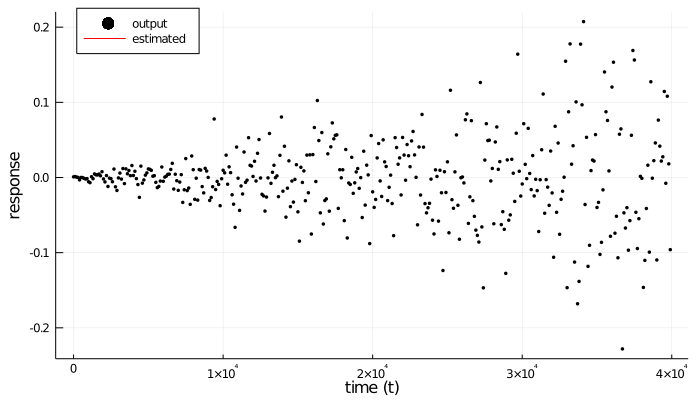

In [12]:
# Extract mean of state marginals
estimated_states = params_zv[1][1,:]

# Plot every n-th time-point to avoid figure size exploding
n = 100

p3 = Plots.scatter(1:n:T_val, output_val[1:n:T_val], color="black", label="output", markersize=2, size=(700,400), xlabel="time (t)", ylabel="response", legend=:topleft)
Plots.plot!(1:n:T_val, estimated_states[1:n:T_val], color="red", linewidth=1, label="estimated")

In [13]:
Plots.savefig(p3, "viz/forecasted_states.png")

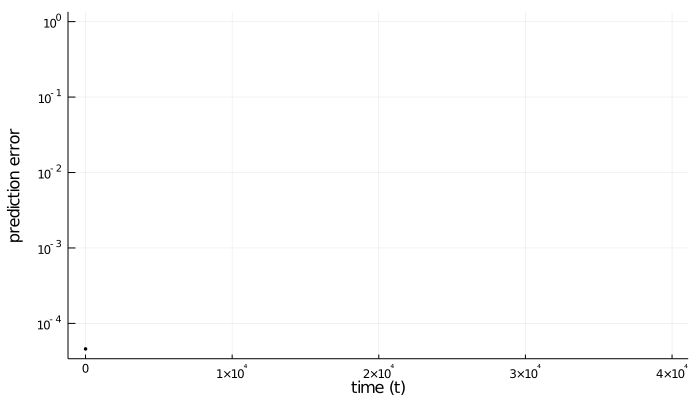

In [14]:
# Error plot
pred_error = (estimated_states .- output_val).^2
p4 = Plots.scatter(3:n:T_val, pred_error[3:n:end], color="black", label="", markersize=2, size=(700,400), xlabel="time (t)", yscale=:log10, ylabel="prediction error")

In [15]:
Plots.savefig(p4, "viz/forecasted_error.png")

In [16]:
println("MSE = "*string(mean(pred_error)))

MSE = NaN


### Baseline: neural network

We have implemented a neural network in Matlab as a baseline method.

In [17]:
using MAT

In [18]:
results = matread("../sota-baselines/training_results.mat")

Dict{String,Any} with 10 entries:
  "options"    => Dict{String,Any}("viewnet"=>0.0,"nIter"=>1000.0,"feedthrough"…
  "details"    => Dict{String,Any}("trainingDetails"=>Dict{String,Any}("states"…
  "fs"         => 610.35
  "yVal"       => [0.0093978 0.012971 … -0.00605201 -0.00722471]
  "error"      => [0.00402748; 0.000125919; … ; 4.0117e-9; 3.17628e-8]
  "model"      => Dict{String,Any}("gradientFcn"=>"defaultderiv","derivFcn"=>"d…
  "yMod"       => [-0.0540646; 0.00174961; … ; -0.00611535; -0.00740293]
  ""           => UInt8[0x00 0x01 … 0x00 0x00]
  "timeTrain"  => [0.0 0.0016384 … 148.392 148.394]
  "modelParam" => Dict{String,Any}("nu"=>1.0,"nx"=>2.0,"transferFcn"=>"tansig",…

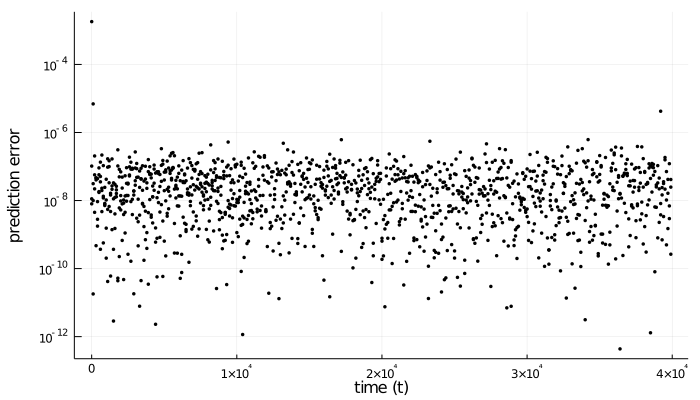

In [19]:
# Error plot
p5 = Plots.scatter(3:n:T_val, results["error"][3:n:end], color="black", label="", markersize=2, size=(700,400), xlabel="time (t)", yscale=:log10, ylabel="prediction error")

In [20]:
println("MSE = "*string(mean(results["error"])))

MSE = 4.461002659364319e-7


## Visualize parameter estimates

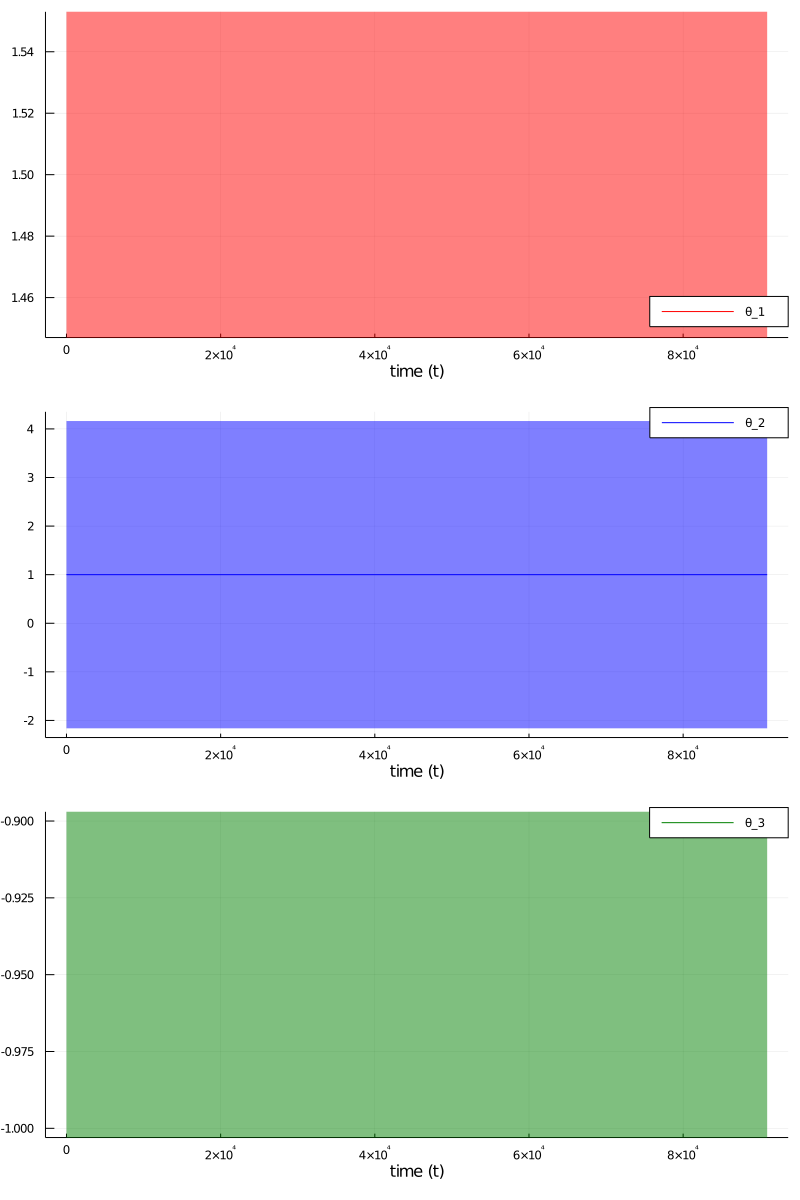

In [21]:
# Extract mean of coefficient marginals
estimated_θ1_mean = params_θ[1][1,2:end]
estimated_θ2_mean = params_θ[1][2,2:end]
estimated_θ3_mean = params_θ[1][3,2:end]
estimated_θ1_std = sqrt.(inv.(params_θ[2][1,1,2:end]))
estimated_θ2_std = sqrt.(inv.(params_θ[2][2,2,2:end]))
estimated_θ3_std = sqrt.(inv.(params_θ[2][3,3,2:end]))

# Plot both coefficients next to each other
p2a = Plots.plot(1:n:T_trn, estimated_θ1_mean[1:n:T_trn], ribbon=[estimated_θ1_std[1:n:T_trn], estimated_θ1_std[1:n:T_trn]], color="red", label="θ_1", xlabel="time (t)", ylim=[1.45, 1.55], legend=:bottomright)
p2b = Plots.plot(1:n:T_trn, estimated_θ2_mean[1:n:T_trn], ribbon=[estimated_θ2_std[1:n:T_trn], estimated_θ2_std[1:n:T_trn]], color="blue", label="θ_2", xlabel="time (t)", legend=:topright)
p2c = Plots.plot(1:n:T_trn, estimated_θ3_mean[1:n:T_trn], ribbon=[estimated_θ3_std[1:n:T_trn], estimated_θ3_std[1:n:T_trn]], color="green", label="θ_3", xlabel="time (t)", ylim=[-1., -0.9], legend=:topright)
p2 = plot(p2a, p2b, p2c, layout=(3,1), size=(800,1200))
# Plots.savefig(p2, "viz/forecasted_estimatedθ.png")

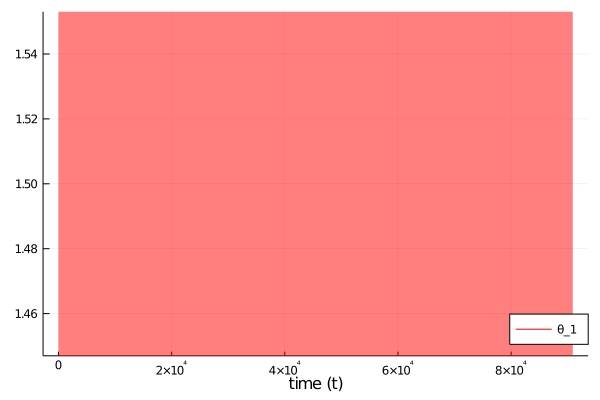

In [22]:
p2a = Plots.plot(1:n:T_trn, estimated_θ1_mean[1:n:T_trn], ribbon=[estimated_θ1_std[1:n:T_trn], estimated_θ1_std[1:n:T_trn]], color="red", label="θ_1", xlabel="time (t)", ylim=[1.45, 1.55], legend=:bottomright, size=(600,400))

In [23]:
Plots.savefig(p2a, "viz/forecasted_estimatedθ1.png")

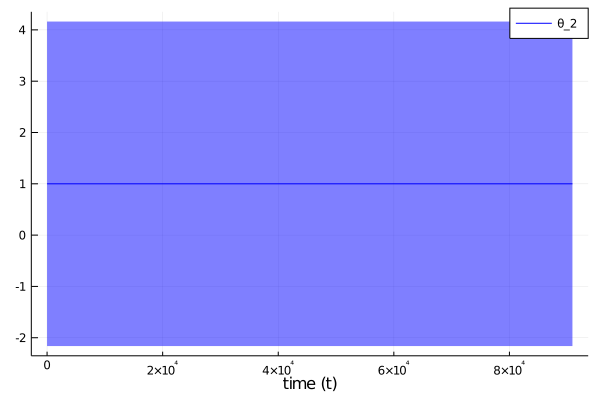

In [24]:
p2b = Plots.plot(1:n:T_trn, estimated_θ2_mean[1:n:T_trn], ribbon=[estimated_θ2_std[1:n:T_trn], estimated_θ2_std[1:n:T_trn]], color="blue", label="θ_2", xlabel="time (t)", legend=:topright, size=(600,400))

In [25]:
Plots.savefig(p2b, "viz/forecasted_estimatedθ2.png")

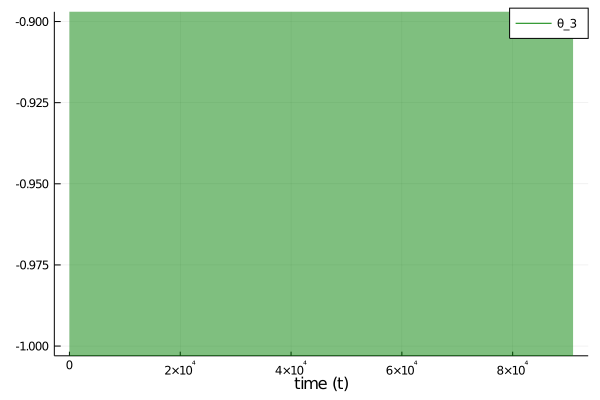

In [26]:
p2c = Plots.plot(1:n:T_trn, estimated_θ3_mean[1:n:T_trn], ribbon=[estimated_θ3_std[1:n:T_trn], estimated_θ3_std[1:n:T_trn]], color="green", label="θ_3", xlabel="time (t)", ylim=[-1., -0.9], legend=:topright, size=(600,400))

In [27]:
Plots.savefig(p2c, "viz/forecasted_estimatedθ3.png")

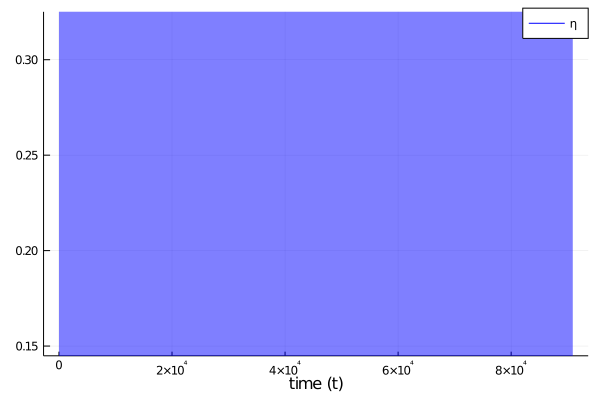

In [28]:
# Extract mean of control coefficient marginals
estimated_η_mean = params_η[1][1,2:end]
estimated_η_std = sqrt.(inv.(params_η[2][1,2:end]))

# Plot both coefficients next to each other
p3 = Plots.plot(1:n:T_trn, estimated_η_mean[1:n:T_trn], ribbon=[estimated_η_std[1:n:T_trn], estimated_η_std[1:n:T_trn]], color="blue", label="η", xlabel="time (t)", ylim=[0.15, .32], size=(600,400))

In [29]:
Plots.savefig(p3, "viz/forecasted_estimatedη.png")

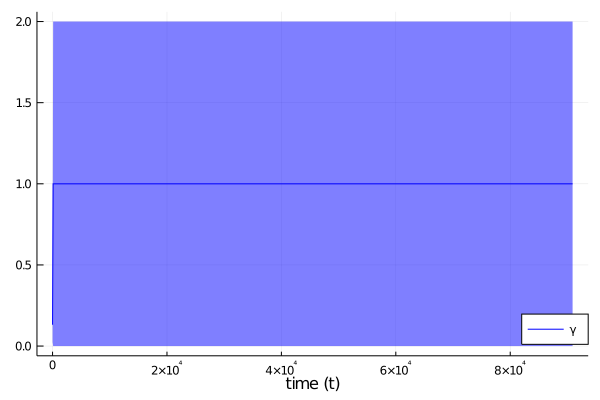

In [30]:
# Extract mean of process precision marginals
estimated_γ_mean = params_γ[1][1,2:end] ./ params_γ[2][1,2:end]
estimated_γ_std = sqrt.(params_γ[1][1,2:end] ./ params_γ[2][1,2:end].^2)

# Plot both coefficients next to each other
p4 = Plots.plot(1:n:T_trn, estimated_γ_mean[1:n:T_trn], ribbon=[estimated_γ_std[1:n:T_trn], estimated_γ_std[1:n:T_trn]], color="blue", label="γ", xlabel="time (t)", size=(600,400), legend=:bottomright)

In [31]:
Plots.savefig(p4, "viz/forecasted_estimatedγ.png")

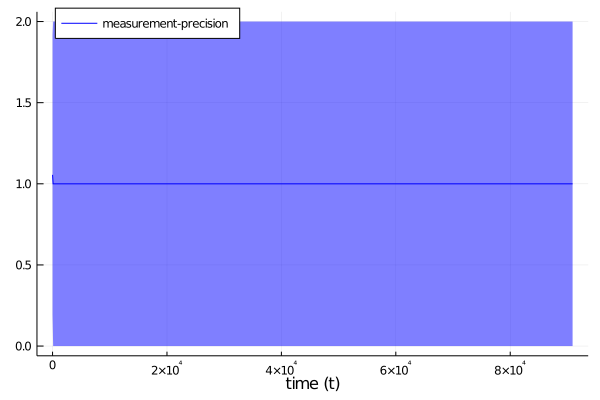

In [32]:
# Extract mean of measurement precision marginals
estimated_ξ_mean = params_ξ[1][1,2:end] ./ params_ξ[2][1,2:end]
estimated_ξ_std = sqrt.(params_ξ[1][1,2:end] ./ params_ξ[2][1,2:end].^2)

# Plot both coefficients next to each other
p8 = Plots.plot(1:n:T_trn, estimated_ξ_mean[1:n:T_trn], ribbon=[estimated_ξ_std[1:n:T_trn], estimated_ξ_std[1:n:T_trn]], color="blue", label="measurement-precision", xlabel="time (t)", size=(600,400), legend=:topleft)

In [33]:
Plots.savefig(p8, "viz/forecasted_measurement-precision.png")